In [2]:
import arviz
import pandas as pd
from model_builder import ModelBuilder
from posteriorplots import predictive_plot, retrodictive_plot

In [3]:
arviz.style.use("arviz-darkgrid")

In [3]:
%load_ext autoreload
%autoreload 2

## Model with socio-eco predictors

- https://fivethirtyeight.com/features/how-fivethirtyeights-2020-presidential-forecast-works-and-whats-different-because-of-covid-19/
-    Jobs, as indicated by nonfarm payrolls.
    Spending, as indicated by real personal consumption expenditures.
    Income, as measured by real disposable personal income.
    Manufacturing, as measured by industrial production.
    Inflation, based on the consumer price index.9
    And the stock market, based on the S&P 500.

In [32]:
TEST_CUTOFF = pd.Timedelta(8, "W")
mb = ModelBuilder(election_to_predict="2017-04-23", test_cutoff=TEST_CUTOFF)
hierarchical_dm = mb.build_model()

/Users/alex_andorra/repos/pollsposition/models/presidential-elections/model_builder.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["countdown"] = dates_to_idx(df["date"], date).astype(int)


In [33]:
idata_hierarchical_dm = mb.sample_all(
    var_names=[
        "latent_popularity",
        "latent_pop_t0",
        "R",
        "noisy_popularity",
        "N_approve",
    ]
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [concentration, election_party_time_coefs, party_time_coefs_raw, lsd_election_party_raw, lsd_election_party_sd, lsd_election_effect, lsd_party_effect_2, lsd_party_effect_1, lsd_intercept, popularity_effect, unemployment_effect, house_election_effects_raw, house_election_effect_sd, house_effects, election_party_intercept, election_party_intercept_sd, party_intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 635 seconds.


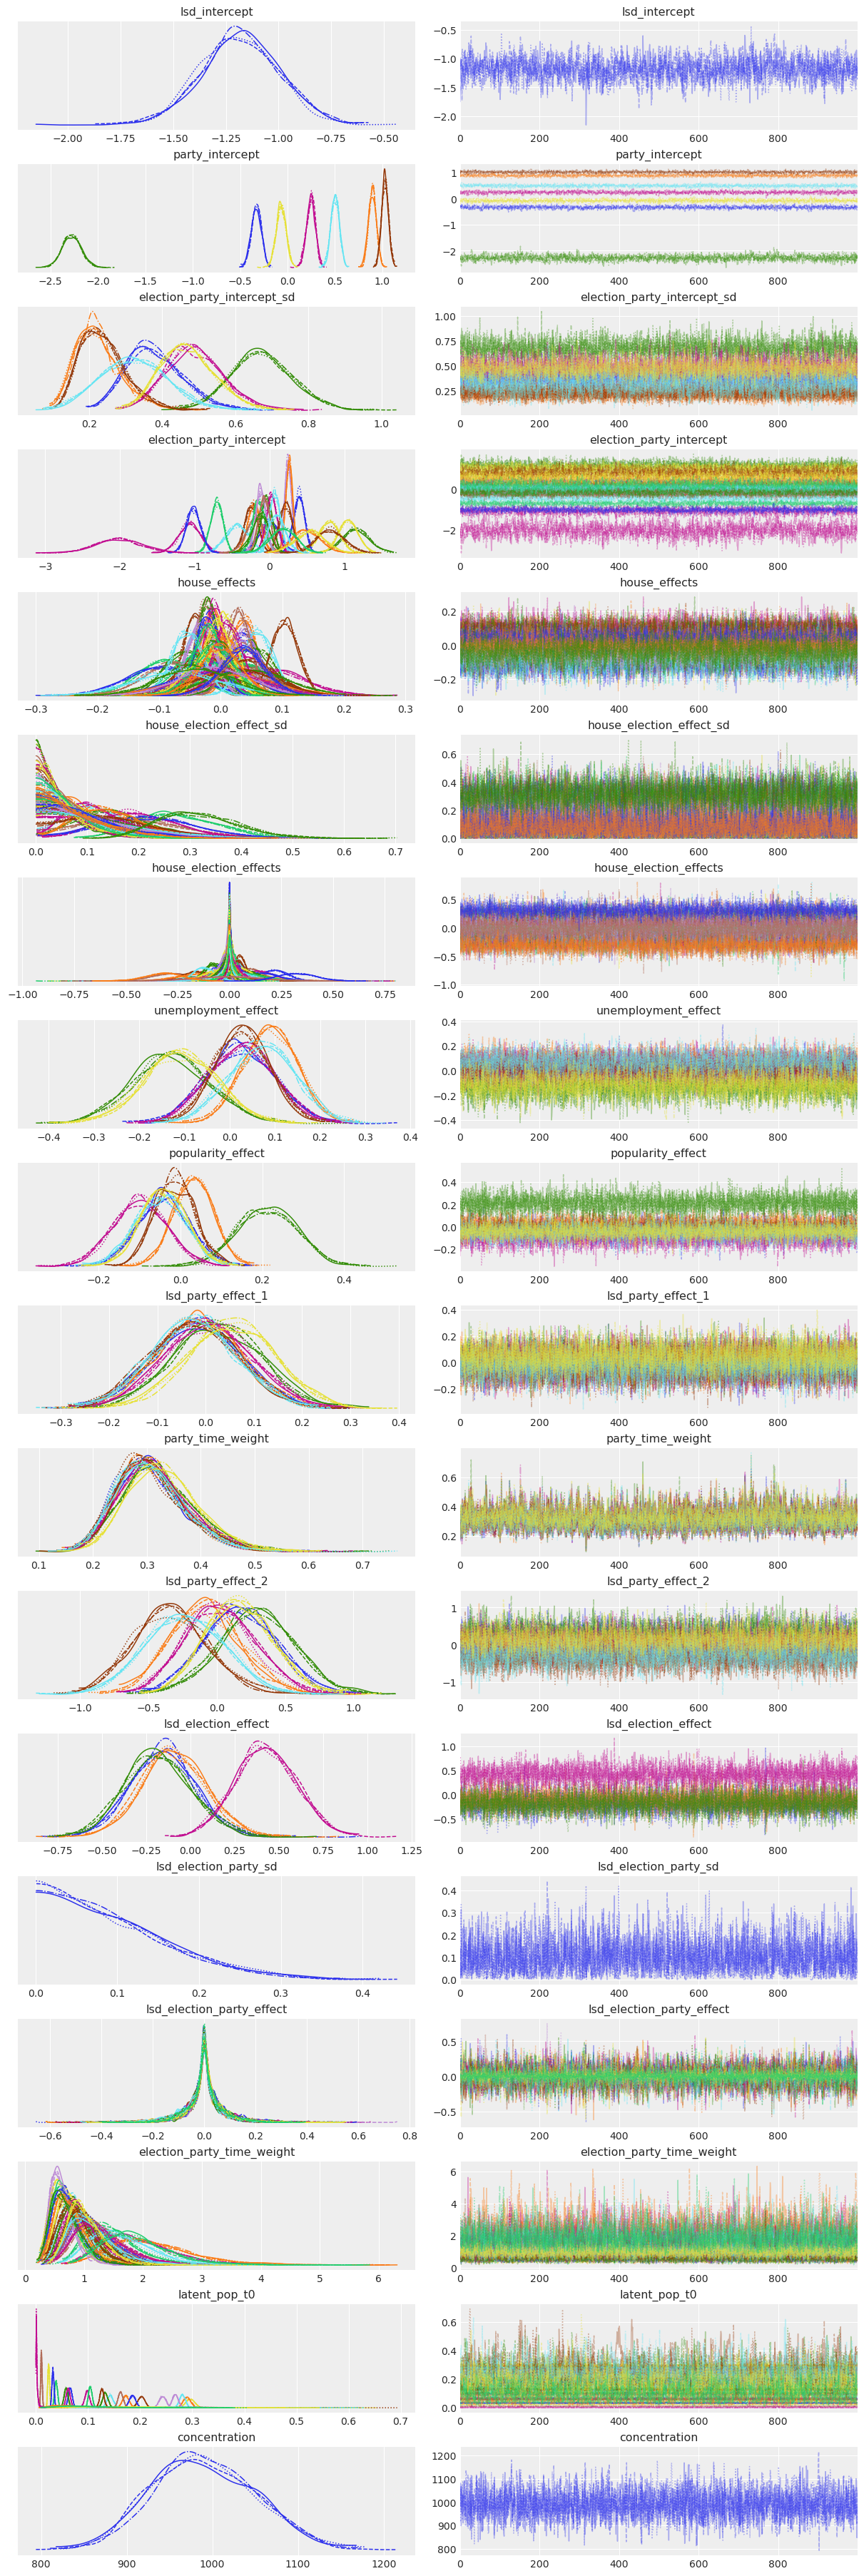

In [34]:
arviz.plot_trace(
    idata_hierarchical_dm,
    var_names=[
        "~time_effect",
        "~time_coefs",
        "~latent_popularity",
        "~noisy_popularity",
        "~raw",
    ],
    filter_vars="regex",
);

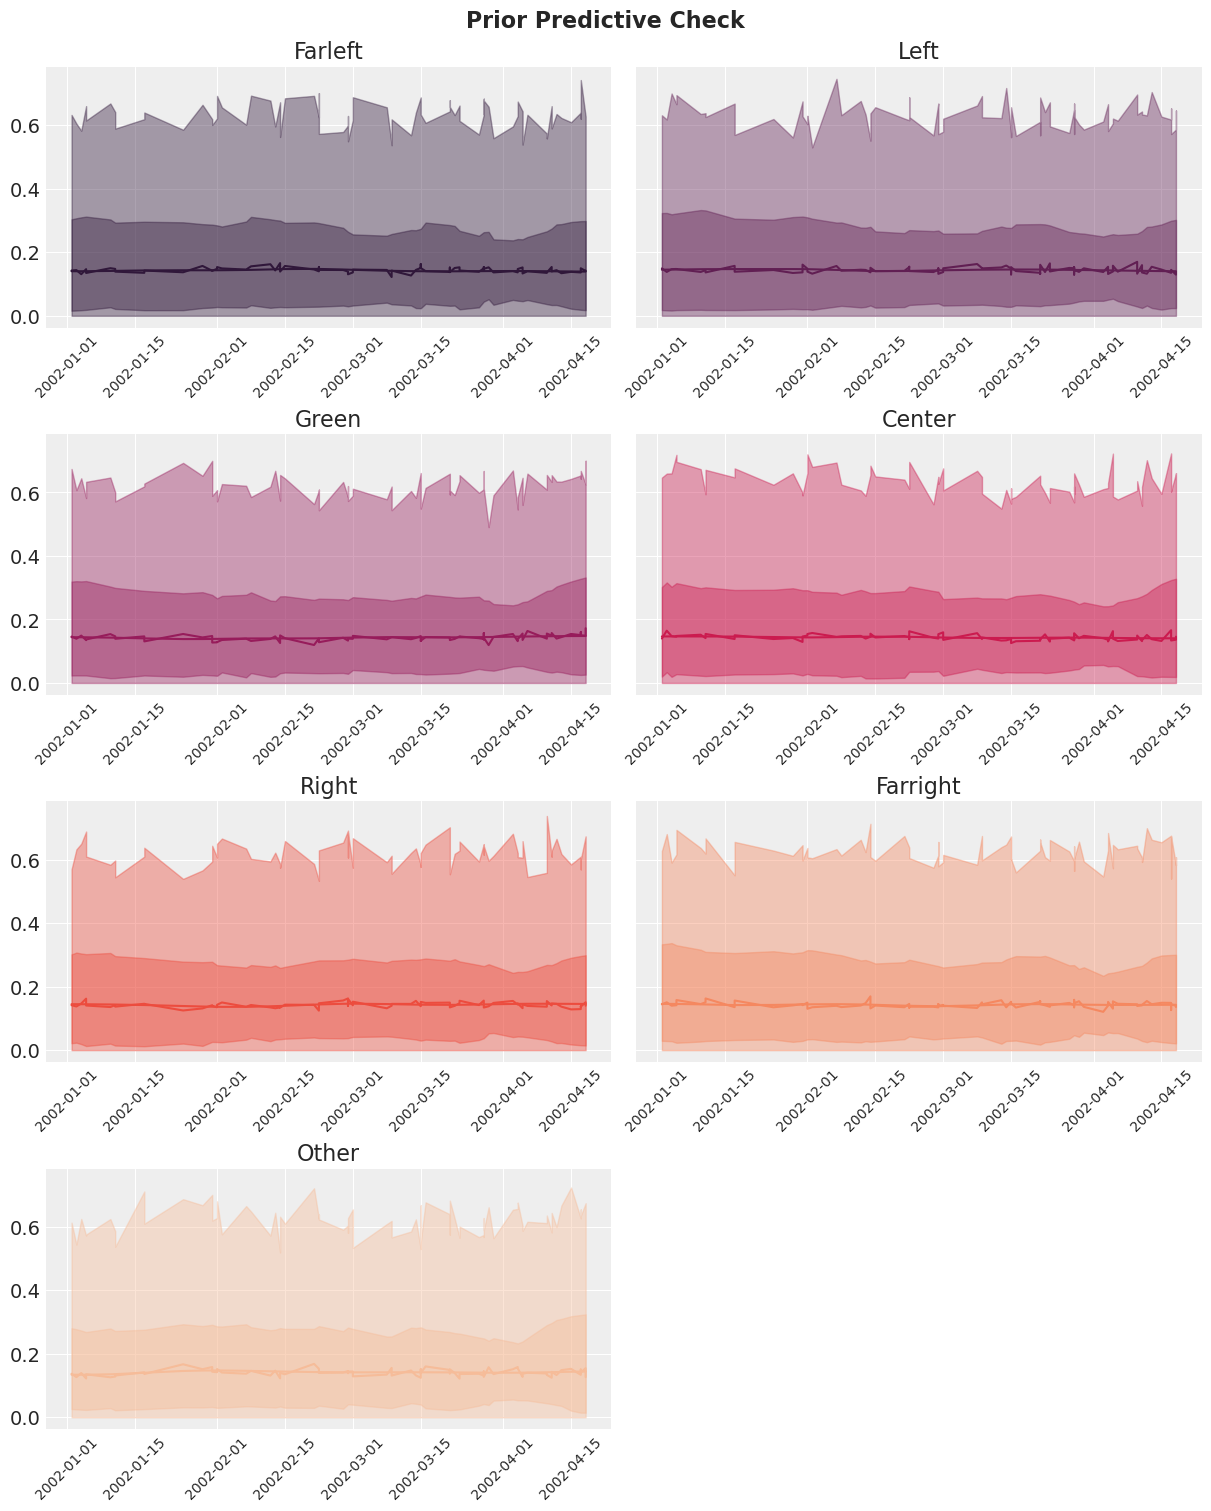

In [63]:
retrodictive_plot(
    idata_hierarchical_dm.sel(
        elections="2002-04-21",
        observations=polls_train[polls_train.dateelection == "2002-04-21"].index,
    ),
    PARTIES_COMPLETE,
    polls_train[polls_train.dateelection == "2002-04-21"],
    group="prior",
)

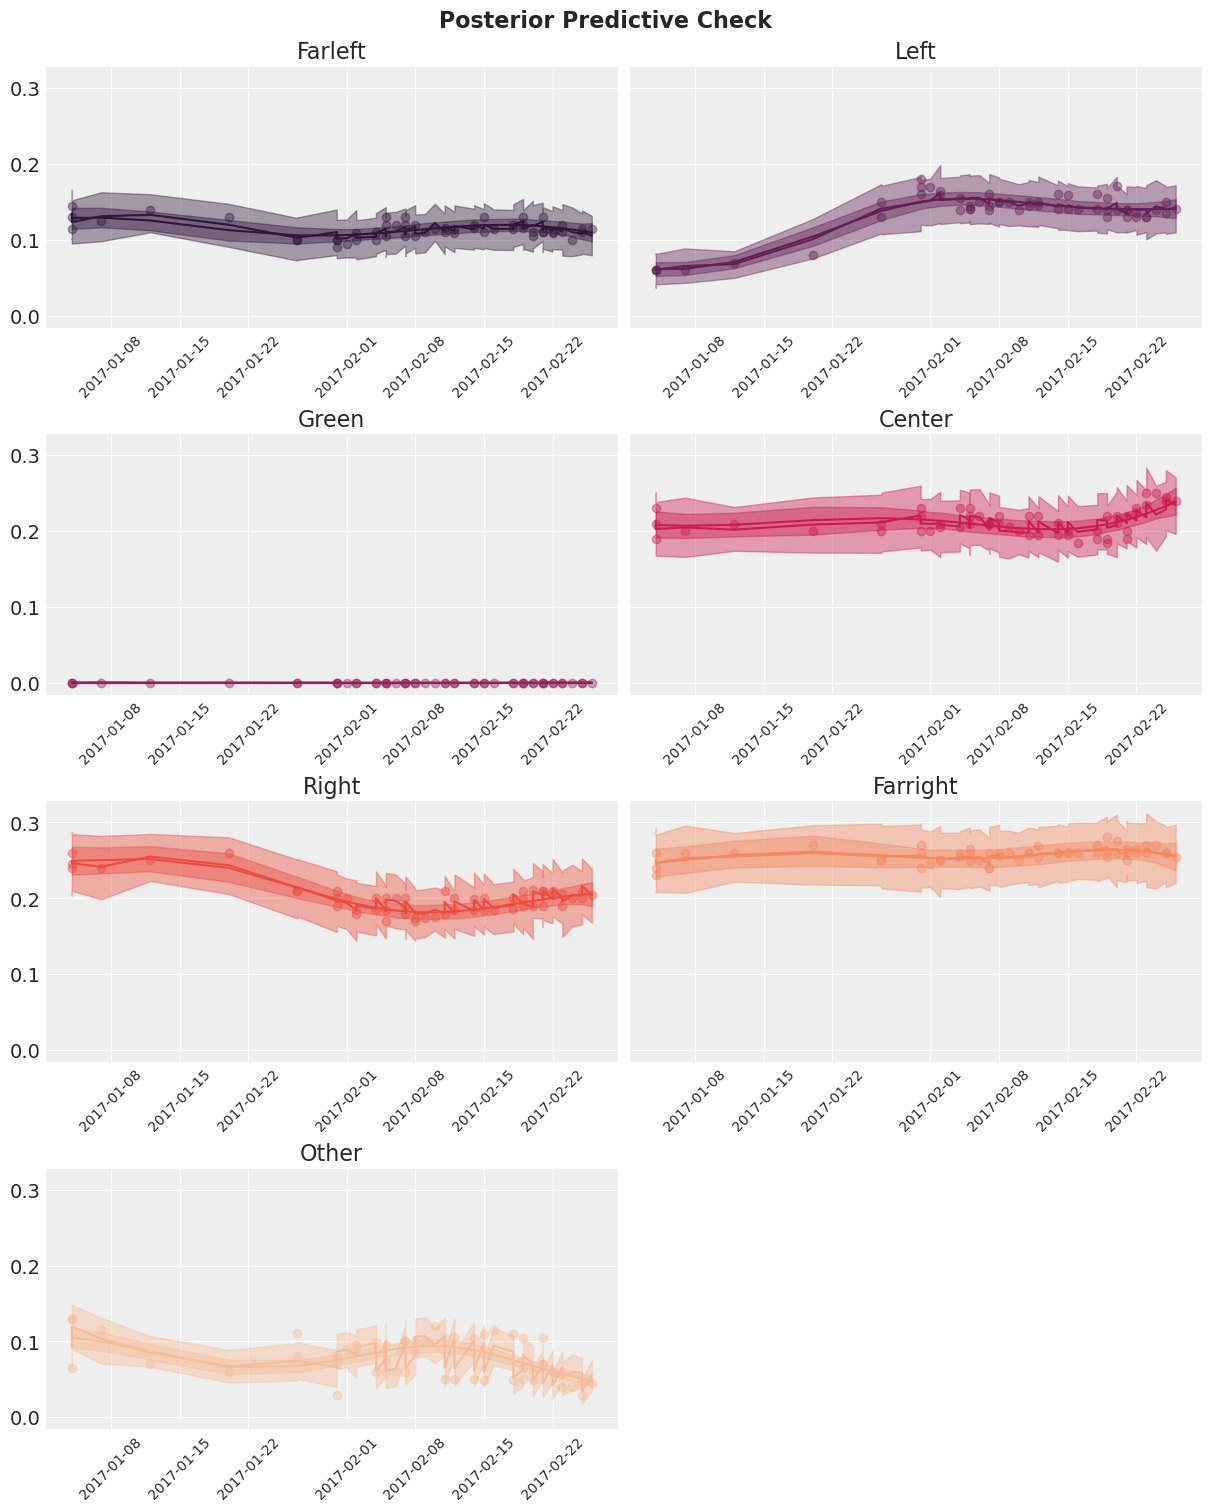

In [35]:
election_date = "2017-04-23"
polls_train = mb.polls_train.copy()
retrodictive_plot(
    idata_hierarchical_dm.sel(
        elections=election_date,
        observations=polls_train[polls_train.dateelection == election_date].index,
    ),
    mb.parties_complete,
    polls_train[polls_train.dateelection == election_date],
    group="posterior",
)

In [36]:
election_forecast = mb.forecast_election(idata_hierarchical_dm)

In [59]:
polls_train.dateelection.unique()

array(['2002-04-21T00:00:00.000000000', '2007-04-22T00:00:00.000000000',
       '2012-04-22T00:00:00.000000000', '2017-04-23T00:00:00.000000000'],
      dtype='datetime64[ns]')

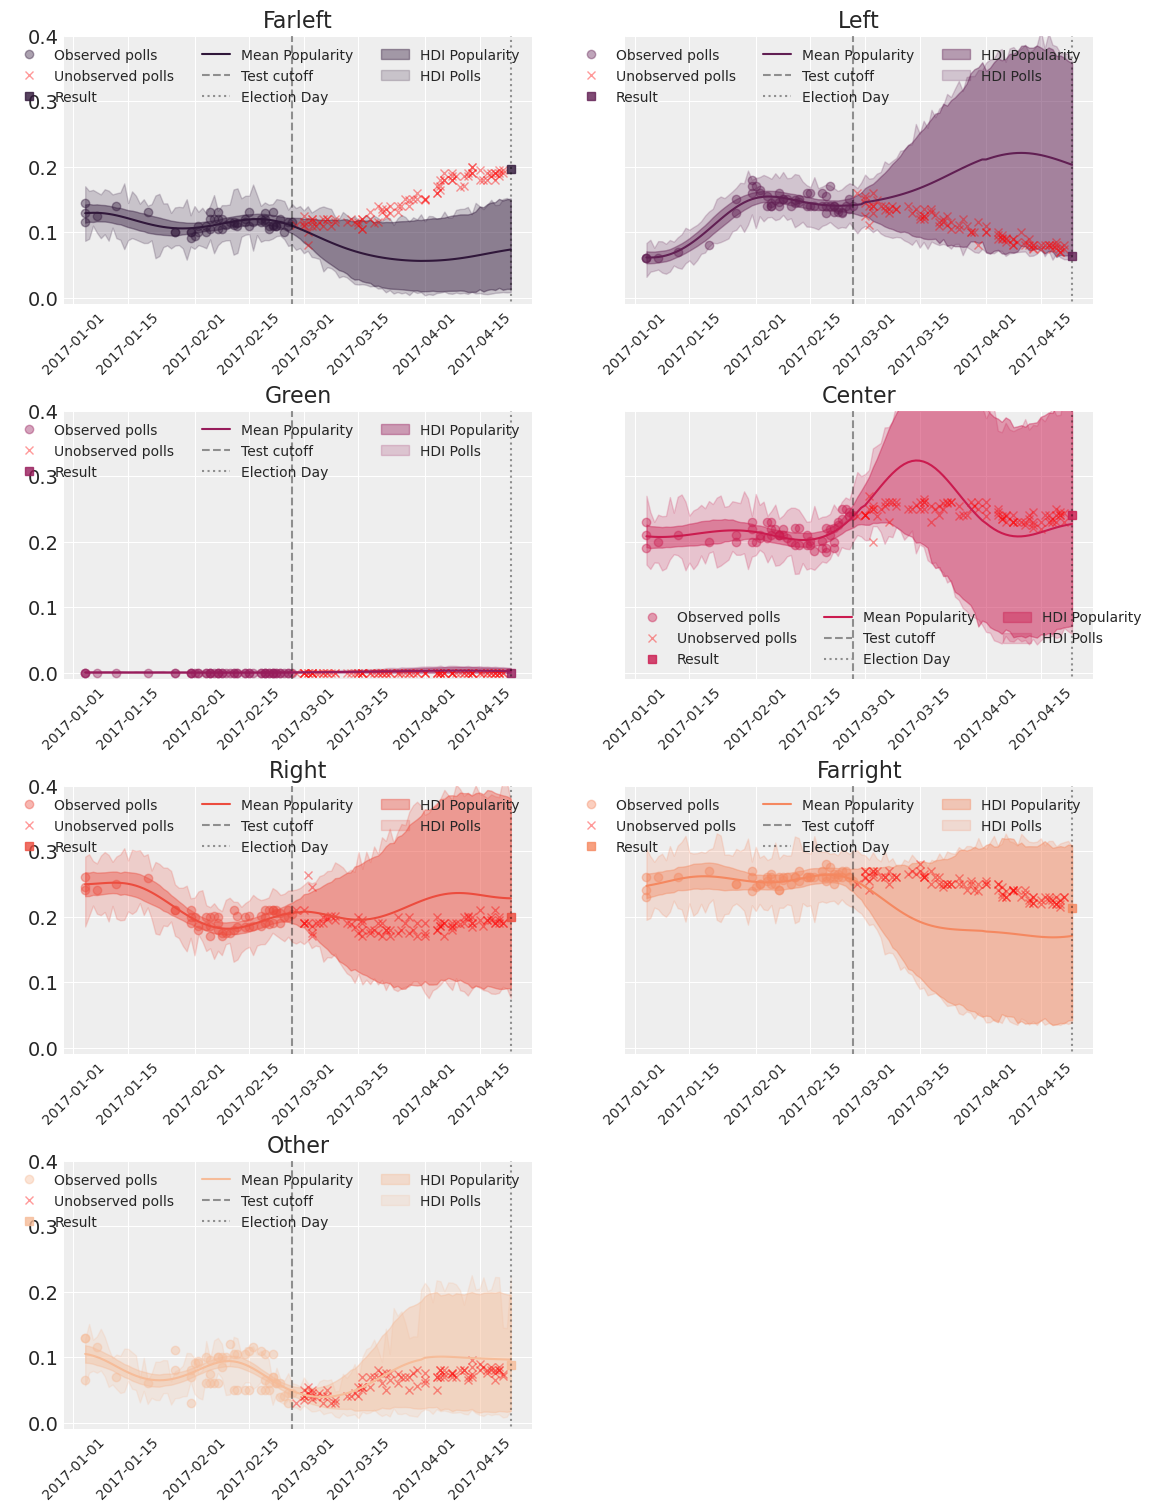

In [39]:
election_date = "2017-04-23"
results = mb.results_raw
polls_test = mb.polls_test

predictive_plot(
    election_forecast,
    mb.parties_complete,
    election_date,
    results[results.dateelection == election_date],
    polls_train[polls_train.dateelection == election_date],
    polls_test[polls_test.dateelection == election_date],
    TEST_CUTOFF,
)
# plt.savefig("ppc.png")

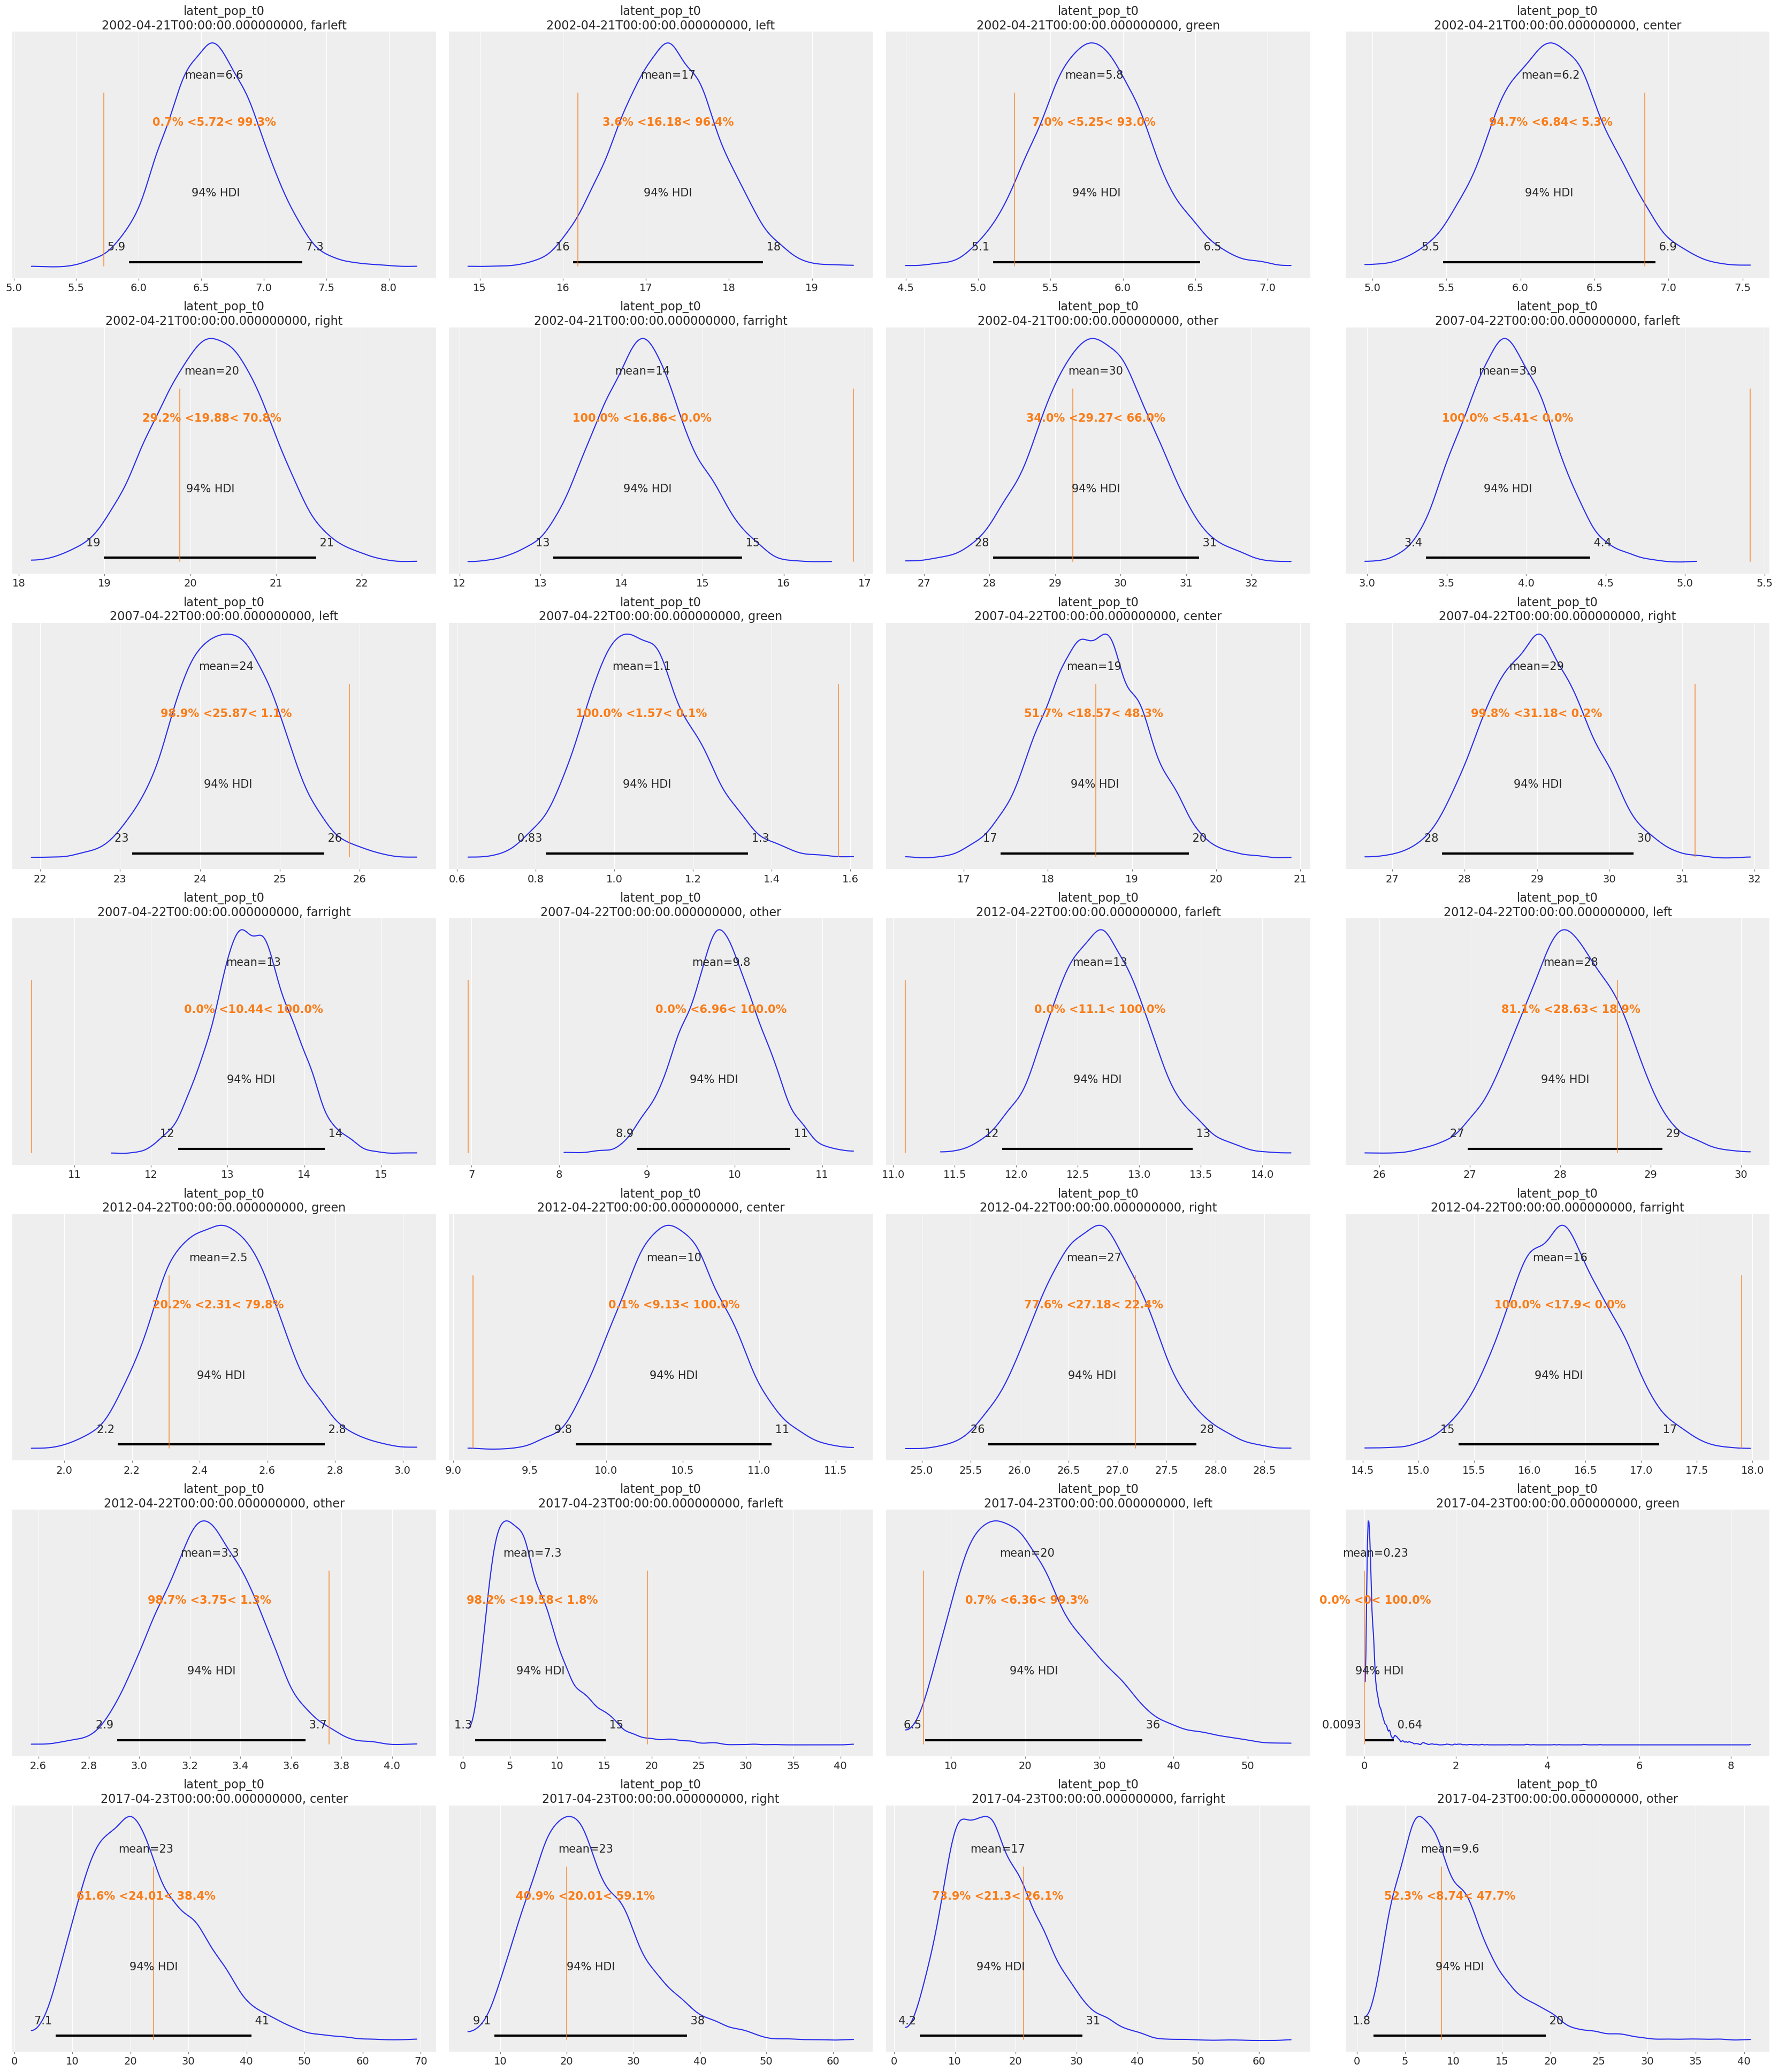

In [40]:
arviz.plot_posterior(
    election_forecast.predictions["latent_pop_t0"] * 100,
    ref_val=results[mb.parties_complete].to_numpy().flatten().tolist(),
);

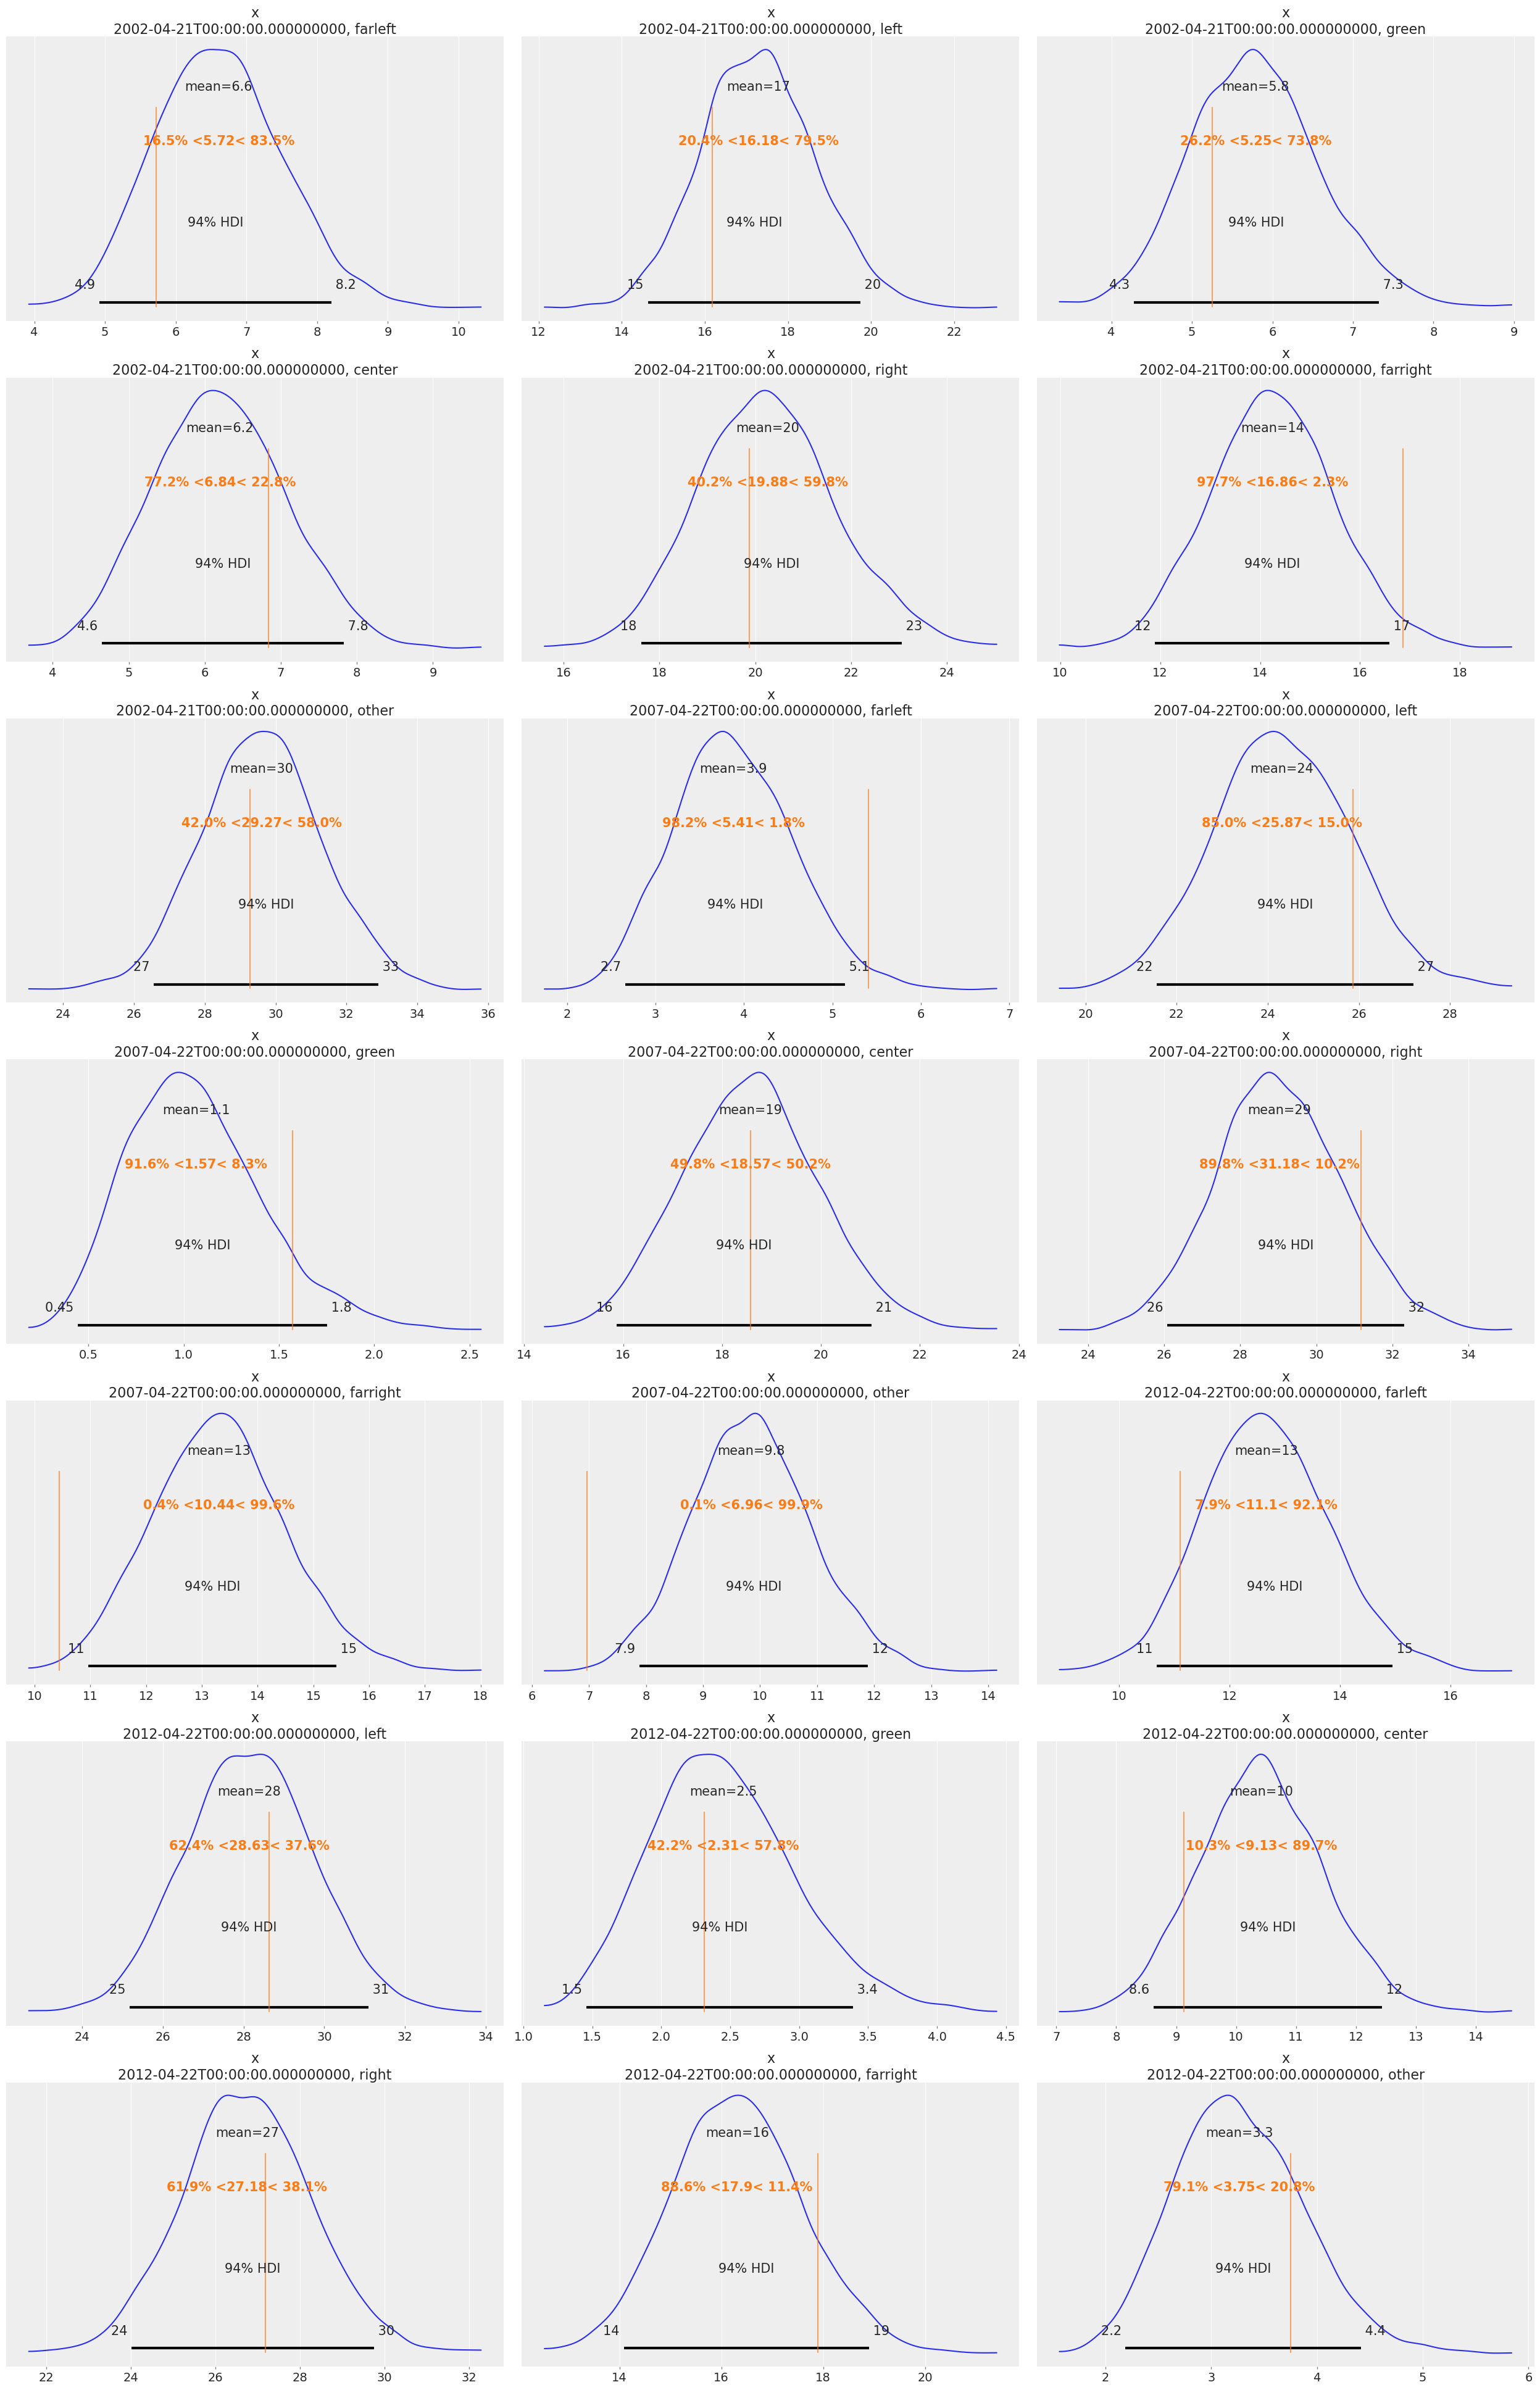

In [42]:
arviz.plot_posterior(
    (
        election_forecast.predictions["R"]
        / election_forecast.predictions_constant_data["results_N"]
    )
    * 100,
    ref_val=results[mb.parties_complete].to_numpy().flatten().tolist(),
);
#plt.savefig("ppc_results.png");

### Add predictors

#### Unemployment

In [12]:
unemp = pd.read_csv(
    "https://raw.githubusercontent.com/pollsposition/data/main/predicteurs/chomage_national_trim.csv",
    sep=";",
    skiprows=2,
).iloc[:, [0, 1]]
unemp.columns = ["date", "unemployment"]
unemp = unemp.sort_values("date")

# as timestamps variables:
unemp.index = pd.period_range(start=unemp.date.iloc[0], periods=len(unemp), freq="Q")
unemp = unemp.drop("date", axis=1)

In [13]:
# add quarters to polls data
polls_train.index = pd.DatetimeIndex(polls_train["date"].values).to_period("Q")
polls_test.index = pd.DatetimeIndex(polls_test["date"].values).to_period("Q")
results_mult.index = pd.DatetimeIndex(results_mult["date"].values).to_period("Q")

In [14]:
# merge with unemployment:
polls_train = polls_train.join(unemp).reset_index(drop=True)
polls_test = polls_test.join(unemp).reset_index(drop=True)
results_mult = results_mult.join(unemp).reset_index(drop=True)


# https://nbviewer.org/github/pollsposition/models/blob/master/district-level/munic_model_prod.ipynb

#### Standardize continous predictors

In [19]:
def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

In [20]:
cont_preds = (
    pd.concat(
        [
            polls_train[["date", "unemployment", "mean_pop"]],
            results_mult[["date", "unemployment", "mean_pop"]],
        ]
    )
    .set_index("date")
    .sort_index()
)
cont_preds_stdz = standardize(cont_preds)

In [21]:
results_preds = cont_preds_stdz.loc[UNIQUE_ELECTIONS]
campaign_preds = cont_preds_stdz.loc[cont_preds.index.difference(UNIQUE_ELECTIONS)]
results_oos = results_mult[results_mult.dateelection != "2017-04-23"].copy()

In [26]:
# covarying GP (transition matrix)

In [ ]:
# https://www.itl.nist.gov/div898/handbook/eda/section3/qqplot.htm
# add other election types (https://github.com/pollsposition/models/blob/master/district-level/munic_model_prod.ipynb)